In [ ]:
!pip install visualkeras
!pip install keras-tuner
!pip install tensorboard


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os


In [ ]:
base_dir = '.'

seed = 1789
shuffle = True

batch_size = 64

validation_split = 0.15

img_height = 150
img_width = 150
image_size=(img_height, img_width)

In [ ]:
import os
import pathlib
import zipfile
import gdown


base_dir = 'C:/Users/YourUsername/Downloads'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)


zip_file_path = os.path.join(base_dir, 'dk-dataset.zip')

# Google Drive file ID
file_id = '1JWpW6JTdV__L-j18QU3wgGrcIdguHl8l'
# Construct the download URL
download_url = f'https://drive.google.com/uc?id={file_id}'


gdown.download(download_url, zip_file_path, quiet=False)

# Unzip data
with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall(base_dir)


dataset_path = os.path.join(base_dir, 'dataset')


data_dir = pathlib.Path(dataset_path)

if data_dir.exists() and data_dir.is_dir():
    print("Data directory exists and is a directory.")
    print("Subdirectories in the dataset:")
    for sub_dir in os.listdir(data_dir):
        full_path = os.path.join(data_dir, sub_dir)
        if os.path.isdir(full_path) and not sub_dir.startswith('.'):
            print(f'  - {sub_dir}{os.path.sep}')
else:
    print(f"Error: The directory {data_dir} does not exist or is not a directory.")


Downloading...
From (original): https://drive.google.com/uc?id=1JWpW6JTdV__L-j18QU3wgGrcIdguHl8l
From (redirected): https://drive.google.com/uc?id=1JWpW6JTdV__L-j18QU3wgGrcIdguHl8l&confirm=t&uuid=0aa8f69a-6611-4775-aaf4-c5dd7fc3e025
To: /content/C:/Users/YourUsername/Downloads/dk-dataset.zip
100%|██████████| 210M/210M [00:01<00:00, 143MB/s]


Data directory exists and is a directory.
Subdirectories in the dataset:
  - train/
  - test/


In [ ]:
train_dir = pathlib.Path(f'{dataset_path}/train')

def get_dataset_and_classes(validation_split, batch_size, image_size):
  train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    shuffle=shuffle,
    image_size=image_size,
    batch_size=batch_size)

  val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    shuffle=shuffle,
    image_size=image_size,
    batch_size=batch_size)

  class_names = train_ds_raw.class_names
  print("class names:", class_names)

  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = train_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds, val_ds, class_names

In [ ]:

train_ds, val_ds, class_names = get_dataset_and_classes(validation_split, batch_size, image_size)


Found 8582 files belonging to 2 classes.
Using 7295 files for training.
Found 8582 files belonging to 2 classes.
Using 1287 files for validation.
class names: ['negative', 'positive']


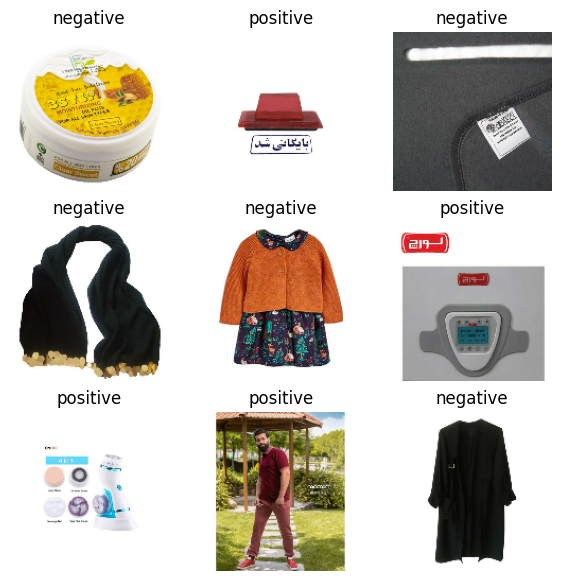

In [ ]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

image_batch, labels_batch = next(iter(train_ds))
print("pixel ranges before normalization:", np.min(image_batch[0]), np.max(image_batch[0]))

train_ds_normalized = train_ds.take(1).map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds_normalized))
print("pixel ranges after normalization:", np.min(image_batch[0]), np.max(image_batch[0]))

pixel ranges before normalization: 0.0 255.0
pixel ranges after normalization: 0.0 1.0


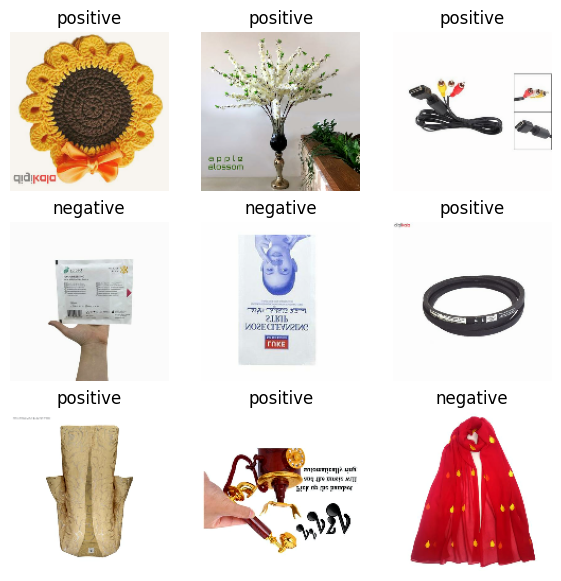

In [ ]:
augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(),
  tf.keras.layers.RandomContrast(0.2),
])

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmentation_layer(images[i])
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:

from datetime import datetime

model_base_dir = f'{base_dir}/models'

def save_model(model, file_name=None):
  if not file_name:
    file_name = datetime.now().strftime("%y-%m-%d-%H-%M")

  model.save(f'{model_base_dir}/{file_name}')

def load_model(file_name):
  model = load_model(f'{model_base_dir}/{file_name}')
  return model

In [ ]:
from tensorflow.keras import layers, models


def build_model(hp):

  inputs = tf.keras.Input(shape=image_size + (3,))

  # Augmentation
  x = layers.RandomContrast(hp.Float('contrast', 0.1, 0.8, sampling='linear', default=0.4))(inputs)
  x = layers.RandomFlip()(x)

  # Preprocessing
  x = layers.Rescaling(1./255)(x)

  # Block 1
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D()(x)

  # Block 2
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(hp.Float('dropout_block2', 0, 0.5, sampling='linear', default=0))(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D()(x)

  # Block 3
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(hp.Float('dropout_block3', 0, 0.5, sampling='linear', default=0))(x)
  x = layers.Conv2D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D()(x)

  # Block 4
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(hp.Float('dropout_block4', 0, 0.5, sampling='linear', default=0))(x)
  x = layers.Conv2D(filters=256, kernel_size=7, activation='relu', padding='same')(x)
  x = layers.Conv2D(filters=256, kernel_size=7, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D()(x)

  flattening_type = hp.Choice("flattening_type", ["flattening", "max_pooling"])

  if flattening_type == "flattening":
    x = layers.Flatten()(x)
  else:
    x = layers.GlobalMaxPooling2D()(x)

  # Head
  x = layers.Dense(hp.Int(f"dense_units_1", 8, 128, step=32, default=8), activation='relu')(x)
  x = layers.Dense(hp.Int(f"dense_units_2", 8, 128, step=32, default=8), activation='relu')(x)
  outputs = layers.Dense(1)(x)

  model = tf.keras.Model(inputs, outputs)

  optimizer_type = hp.Choice("optimizer", ["adam", "sgd"],  default="adam")

  if optimizer_type == "adam":
    optimizer=tf.keras.optimizers.Adam(
      learning_rate=hp.Float('adam_learning_rate', 3e-4, 1, sampling='log', default=1e-3),
      beta_1=hp.Float('adam_beta_1', 0.9, 1, sampling='log', default=0.9),
      beta_2=hp.Float('adam_beta_2', 0.9, 1, sampling='log', default=0.999),
      name='Adam',
      )
  else:
    nesterov = hp.Choice("sgd_nesterov", ["True", "False"])
    optimizer=tf.keras.optimizers.SGD(
      learning_rate=hp.Float('sgd_learning_rate', 3e-4, 1, sampling='log', default=1e-2),
      momentum=hp.Float('sgd_momentum', 0, 1, sampling='log', default=0),
      nesterov=(nesterov == "True"),
      name='SGD',
    )

  model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
  )

  return model

In [ ]:
pip install --upgrade tensorflow keras


In [ ]:
pip install tensorflow keras visualkeras keras-tuner


MODEL SUMMARY

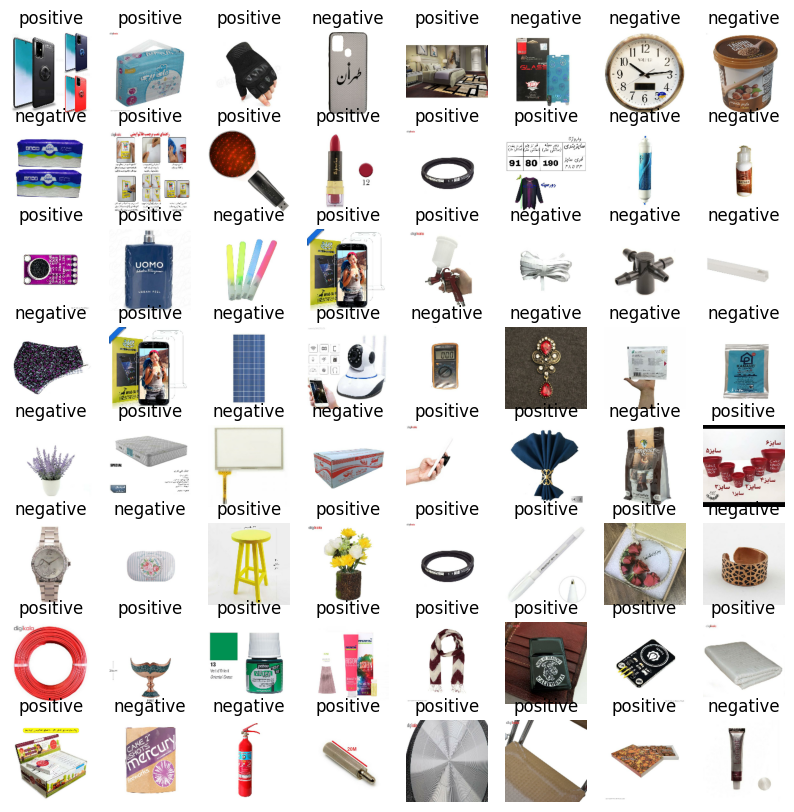

In [ ]:
train_batch_images, train_batch_labels = next(iter(train_ds))
train_batch_images.shape, train_batch_labels.shape

plt.figure(figsize=(10, 10))
for i in range(64):
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(train_batch_images[i].numpy().astype("uint8"))
  plt.title(class_names[train_batch_labels[i]])
  plt.axis("off")

In [ ]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:

import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers


<ipython-input-23-aefb8907fb7a>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
def build_model(hp):
    model = keras.Sequential()



    model.add(layers.InputLayer(input_shape=(150, 150, 3)))



    hp_filters = hp.Int('filters', min_value=32, max_value=256, step=32)
    model.add(layers.Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())


    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))


    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:

hp = kt.HyperParameters()

model = build_model(hp)

history = model.fit(
  x=train_batch_images,
  y=train_batch_labels,
  validation_data=(train_batch_images, train_batch_labels),
  epochs=50
)


Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 1776.1202 - accuracy: 0.3125 - val_loss: 2240.4531 - val_accuracy: 0.4219
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 1236.9536 - accuracy: 0.4219 - val_loss: 32.7706 - val_accuracy: 0.1719
Epoch 3/50
2/2 [==============================] - 3s 3s/step - loss: 16.6617 - accuracy: 0.4531 - val_loss: 2.3821 - val_accuracy: 0.8125
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 1.6399 - accuracy: 0.7500 - val_loss: 1.4319 - val_accuracy: 0.6719
Epoch 5/50
2/2 [==============================] - 3s 2s/step - loss: 1.2597 - accuracy: 0.7188 - val_loss: 1.0077 - val_accuracy: 0.7344
Epoch 6/50
2/2 [==============================] - 4s 3s/step - loss: 0.7802 - accuracy: 0.7500 - val_loss: 0.3977 - val_accuracy: 0.8281
Epoch 7/50
2/2 [==============================] - 2s 1s/step - loss: 0.4184 - accuracy: 0.8125 - val_loss: 0.4690 - val_accuracy: 0.8281
Epoch 8/50
2/2 [==============

In [ ]:
model.evaluate(train_batch_images, train_batch_labels)

2/2 [==============================] - 0s 210ms/step - loss: 0.0469 - accuracy: 0.9844


[0.04689276963472366, 0.984375]

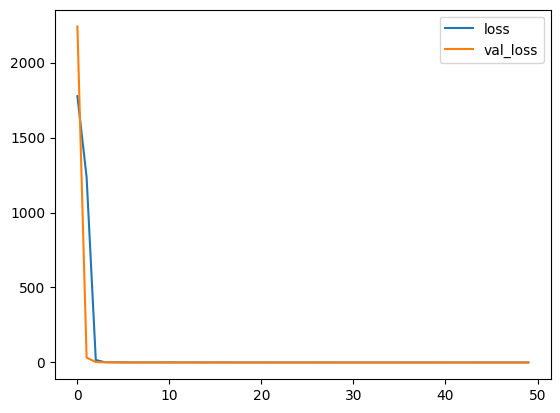

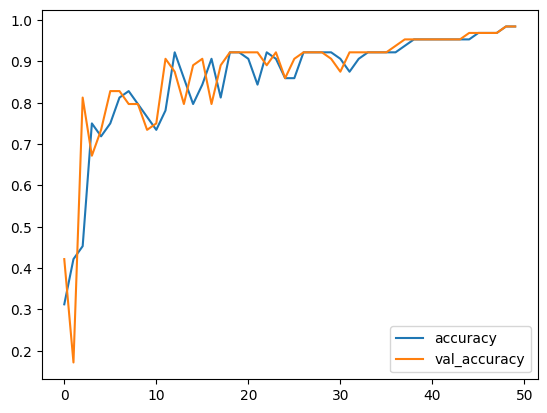

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

21/21 [==============================] - 11s 507ms/step
Labels List Shape: (1287,) Type: <class 'numpy.ndarray'> Unique values: [0 1]
Preds List Shape: (1287,) Type: <class 'numpy.ndarray'> Unique values: [0 1]

Confusion Matrix:
 [[485 187]
 [429 186]]
Class 0:
  True Positive: 485
  False Positive: 429
  False Negative: 187
  True Negative: 186
Class 1:
  True Positive: 186
  False Positive: 187
  False Negative: 429
  True Negative: 485


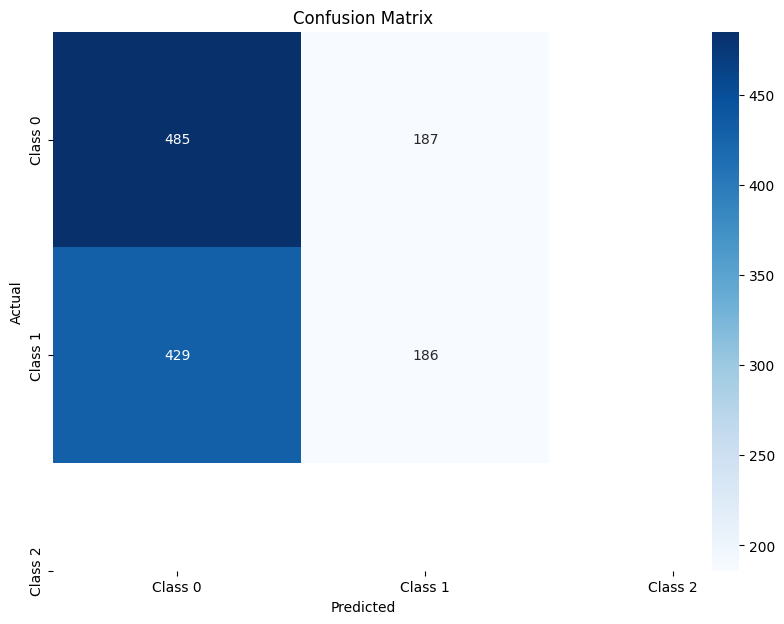

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


labels_list = get_labels_from_tfdataset(val_ds)
labels_list = labels_list.astype(int)


preds_list_raw = model.predict(val_ds)


preds_list = np.argmax(preds_list_raw, axis=1)


print("Labels List Shape:", labels_list.shape, "Type:", type(labels_list), "Unique values:", np.unique(labels_list))
print("Preds List Shape:", preds_list.shape, "Type:", type(preds_list), "Unique values:", np.unique(preds_list))


conf_matrix = confusion_matrix(labels_list, preds_list)
accuracy = accuracy_score(labels_list, preds_list)



print("\nConfusion Matrix:\n", conf_matrix)

for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    tn = conf_matrix.sum() - (tp + fp + fn)
    print(f"Class {i}:")
    print(f"  True Positive: {tp}")
    print(f"  False Positive: {fp}")
    print(f"  False Negative: {fn}")
    print(f"  True Negative: {tn}")


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("Unique classes in labels_list:", np.unique(labels_list))
print("Class counts:", np.bincount(labels_list))


Unique classes in labels_list: [0 1]
Class counts: [672 615]


In [ ]:
print("Shape of preds_list_raw:", preds_list_raw.shape)


Shape of preds_list_raw: (1287, 10)


In [ ]:
from sklearn.preprocessing import label_binarize

num_classes = preds_list_raw.shape[1]
labels_binarized = label_binarize(labels_list, classes=range(num_classes))


In [ ]:
# Extract the probability for the positive class (class 1)
preds_prob = preds_list_raw[:, 1]


In [ ]:
labels_binarized = labels_list


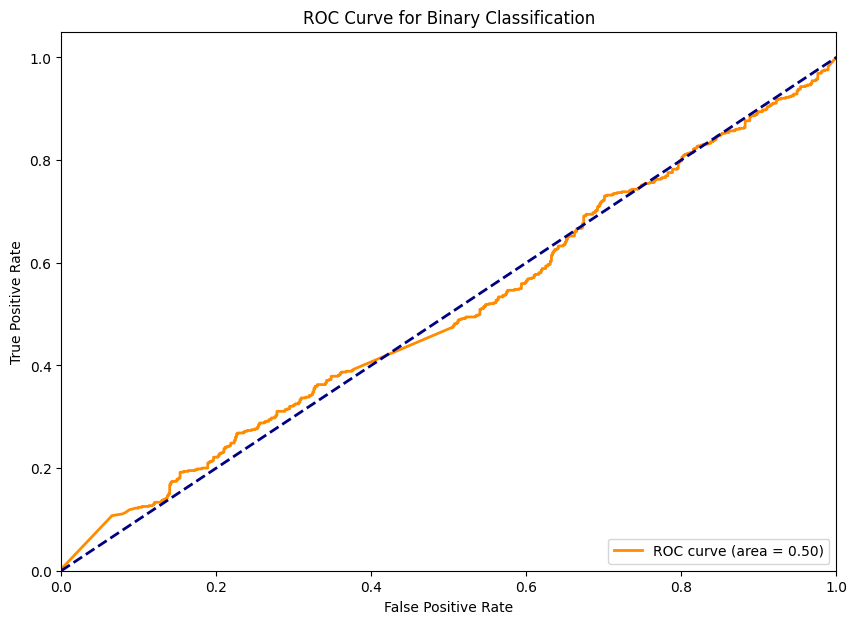

ROC AUC Score: 0.50


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


roc_auc = roc_auc_score(labels_binarized, preds_prob)


fpr, tpr, _ = roc_curve(labels_binarized, preds_prob)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Classification")
plt.legend(loc="lower right")
plt.show()


print(f"ROC AUC Score: {roc_auc:.2f}")
